In [ ]:
import os
import random
import time
import heapq
import math
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# Map Generator

In [ ]:
def ship_generator(D, loop_chance=0.5, seed=None):
  if seed:
    random.seed(seed)

  # blocked = 1, open = 0
  ship = np.ones((D, D), dtype=int)

  # picking a random cell in the start and opening it
  start_x, start_y = random.randint(1, D-2), random.randint(1, D-2)
  ship[start_x, start_y] = 0

  # returns valid neighbors (up, down, left, right)
  def neighbors(x, y):
    dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    return [(x+dx, y+dy) for dx, dy in dirs if 0 <= x+dx < D and 0 <= y+dy < D]

  changed = True
  while changed:
    changed = False
    candidates = []
    for i in range(1, D-1):
      for j in range(1, D-1):
        if ship[i, j] == 1:
          open_neighbors = sum(1 - ship[x, y] for x, y in neighbors(i, j))
          if open_neighbors == 1:
              candidates.append((i, j))

    if candidates:
      x, y = random.choice(candidates)
      ship[x, y] = 0
      changed = True

  # identifying the dead ends
  dead_ends = []
  for i in range(1, D-1):
    for j in range(1, D-1):
      if ship[i, j] == 0:
        open_neighbors = [(x, y) for x, y in neighbors(i, j) if ship[x, y] == 0]
        if len(open_neighbors) == 1:
          dead_ends.append((i, j))

  # opening some dead ends to create some loops
  for (x, y) in dead_ends:
    if random.random() < loop_chance:
      closed_neighbors = [(dx, dy) for dx, dy in neighbors(x, y) if ship[dx, dy] == 1]
      if closed_neighbors:
        cx, cy = random.choice(closed_neighbors)
      ship[cx, cy] = 0

  return ship

# Baseline Strategy

In [ ]:
# Returns the initial belief set (L) for the bot.
def initial_bot_set(ship, mode="all", fraction=0.5, radius=3, dist_from_to=None):
  open_cells = [(i, j) for i in range(ship.shape[0]) for j in range(ship.shape[1]) if ship[i, j] == 0]

  # Mode 1: all open cells
  if mode == "all":
    return set(open_cells)

  # Mode 2: hardest subset (cells far apart)
  elif mode == "hardest" and dist_from_to:
    best_L = None
    max_sum_dist = -1
    for _ in range(200):  # random samples
      subset = random.sample(open_cells, min(5, len(open_cells)))
      total_dist = sum(
          dist_from_to.get((a, b), 0)
          for a in subset for b in subset if a != b
      )
      if total_dist > max_sum_dist:
        best_L = subset
        max_sum_dist = total_dist
    return set(best_L)

  else:
    raise ValueError(f"Unknown mode: {mode}")

In [ ]:
def move(L, ship, action):
  new_L = set()

  for (i, j) in L:
    ni, nj = i, j

    if action == 'UP' and i > 0 and ship[i-1, j] == 0:
      ni -= 1
    elif action == 'DOWN' and i < ship.shape[0]-1 and ship[i+1, j] == 0:
      ni += 1
    elif action == 'LEFT' and j > 0 and ship[i, j-1] == 0:
      nj -= 1
    elif action == 'RIGHT' and j < ship.shape[1]-1 and ship[i, j+1] == 0:
      nj += 1

    new_L.add((ni, nj))

  return new_L

In [ ]:
# Returns path from start to target using BFS
def shortest_path_bfs(ship, start, end):
  dirs = {'UP': (-1,0), 'DOWN': (1,0), 'LEFT': (0,-1), 'RIGHT': (0,1)}

  queue = deque([(start, [])])
  visited = {start}

  while queue:
    (x, y), path = queue.popleft()
    if (x, y) == end:
      return path
    for action, (dx, dy) in dirs.items():
      nx, ny = x + dx, y + dy
      if 0 <= nx < ship.shape[0] and 0 <= ny < ship.shape[1] and ship[nx, ny] == 0:
        if (nx, ny) not in visited:
          visited.add((nx, ny))
          queue.append(((nx, ny), path + [action]))

  return None

In [ ]:
def baseline_strategy(ship):
  L = initial_bot_set(ship)
  dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]

  dead_ends = []
  for i in range(ship.shape[0]):
    for j in range(ship.shape[1]):
      if ship[i, j] == 0:
        open_neighbors_count = 0
        for di, dj in dirs:
          ni, nj = i + di, j + dj
          if 0 <= ni < ship.shape[0] and 0 <= nj < ship.shape[1] and ship[ni, nj] == 0:
            open_neighbors_count += 1
        if open_neighbors_count == 1:
          dead_ends.append((i, j))

  # Check if dead_ends is not empty before choosing a target
  if not dead_ends:
    print("No dead ends found in the ship.")
    return [], set() # Return empty sequence and empty set if no dead ends

  target = random.choice(dead_ends)
  sequence = []

  while len(L) > 1:
    bot = random.choice(list(L))
    path = shortest_path_bfs(ship, bot, target)

    if path is None:
      break

    for action in path:
      L = move(L, ship, action)
      sequence.append(action)
      if len(L) == 1:
        break

  return sequence, L

In [ ]:
def plot_ship(ship, L, title, target=None):
  fig, ax = plt.subplots(figsize=(10, 10))
  cmap = plt.cm.gray_r  # 0 = open (white), 1 = wall (black)
  ax.imshow(ship, cmap = cmap, origin = "upper")

  if L:
    Li, Lj = zip(*L)
    ax.scatter(Lj, Li, c='red', marker='o', label='Possible bot')

  if target:
    ax.scatter(target[1], target[0], c='blue', marker='X', s=100, label='Target')

  ax.set_xticks(np.arange(-.5, ship.shape[1], 1), minor=True)
  ax.set_yticks(np.arange(-.5, ship.shape[0], 1), minor=True)
  ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
  ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
  ax.legend(loc="upper right")
  ax.set_title(title)
  plt.show()


def show_initial_mid_final(ship, sequence, target=None):
  L_init = initial_bot_set(ship)

  mid_index = len(sequence) // 2
  L_mid = set(L_init)
  for action in sequence[:mid_index]:
    L_mid = move(L_mid, ship, action)


  L_final = set(L_mid)
  for action in sequence[mid_index:]:
    L_final = move(L_final, ship, action)

  plot_ship(ship, L_init, "Initial Ship", target)
  plot_ship(ship, L_mid, "Midway Ship", target)
  plot_ship(ship, L_final, "Final Ship with localized bot", target)

In [ ]:
ship = ship_generator(D=10, loop_chance=0.5, seed=42)

start = time.time()
sequence, final_L = baseline_strategy(ship)
end = time.time()

print("Baseline Move Sequence: ", sequence)
print("Total moves: ", len(sequence))
print("Final position: ", final_L)
print("Computation Time (in seconds): ", end - start)

Baseline Move Sequence:  ['LEFT', 'LEFT', 'UP', 'LEFT', 'LEFT', 'UP', 'UP', 'UP', 'DOWN', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'UP', 'LEFT', 'LEFT', 'LEFT', 'UP', 'DOWN', 'DOWN', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'LEFT', 'LEFT', 'UP', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'UP', 'UP', 'UP', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'UP', 'UP', 'UP', 'DOWN', 'DOWN', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'UP', 'UP', 'UP']
Total moves:  70
Final position:  {(4, 5)}
Computation Time (in seconds):  0.0012576580047607422


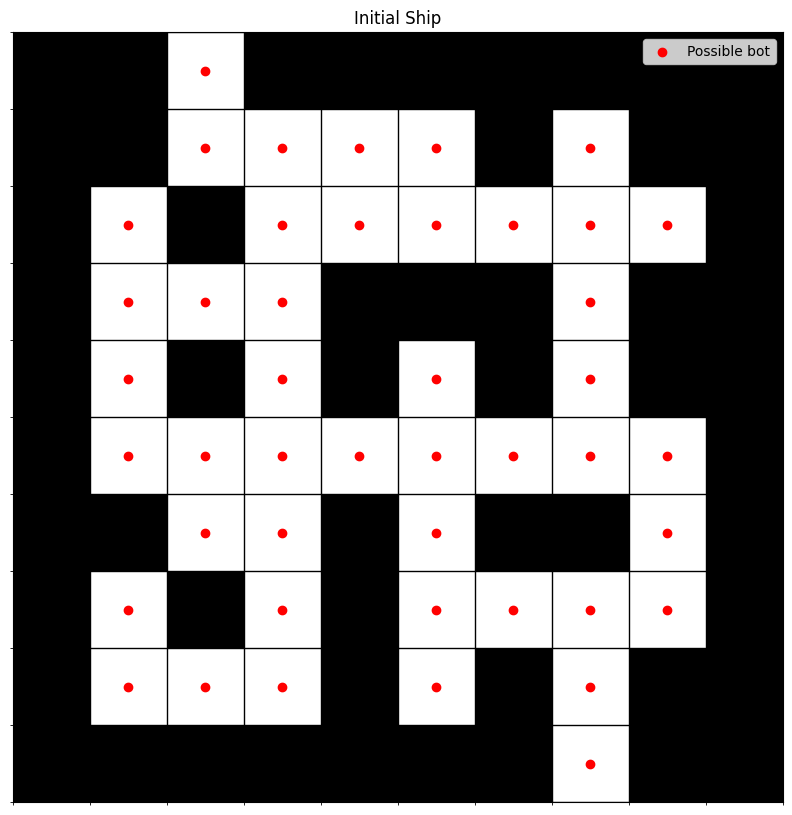

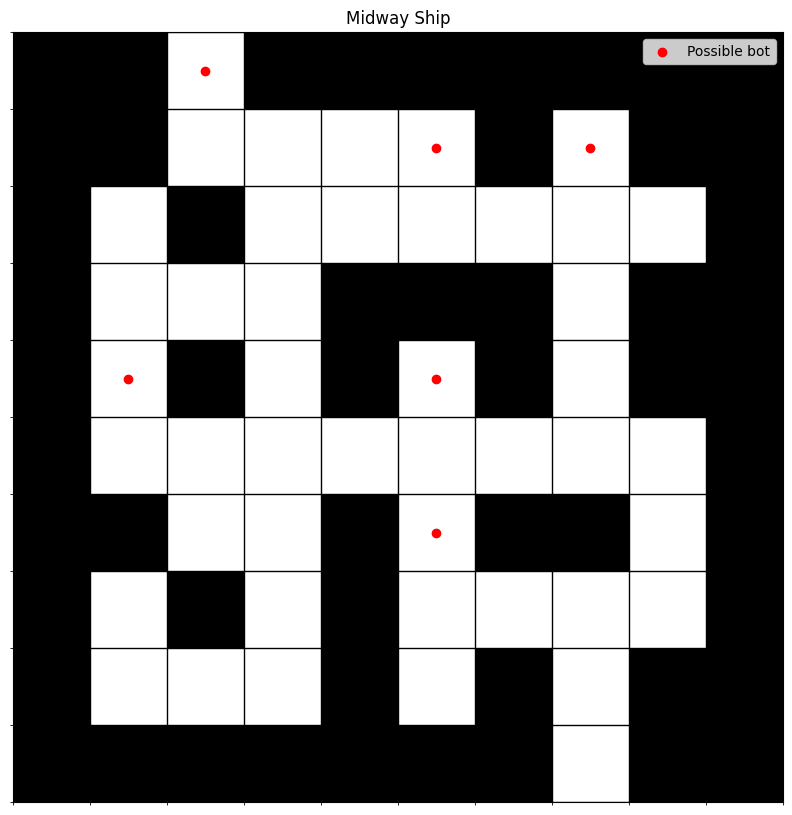

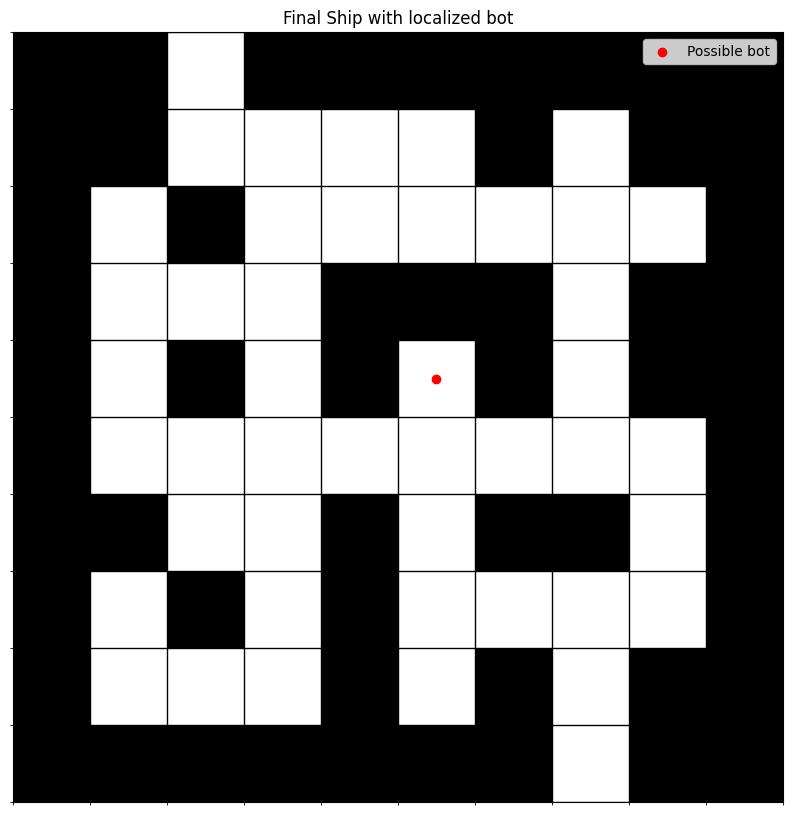

In [ ]:
show_initial_mid_final(ship, sequence)

# Optimal Strategy

In [ ]:
def precompute_distances(ship):
  rows, cols = ship.shape

  open_cells = [(i, j) for i in range(rows) for j in range(cols) if ship[i, j] == 0]

  dist_from_to = {}

  # For each open cell, compute shortest distance to all other reachable cells using BFS
  for start in open_cells:
    dist = {start: 0}
    q = deque([start])

    while q:
      x, y = q.popleft()

      # Explore all 4 possible movement directions (up, down, left, right)
      for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
        nx, ny = x + dx, y + dy

        # Check if new position is valid and unvisited
        if 0 <= nx < rows and 0 <= ny < cols and ship[nx, ny] == 0 and (nx, ny) not in dist:
          dist[(nx, ny)] = dist[(x, y)] + 1
          q.append((nx, ny))

    # After BFS from one start cell, store all computed distances
    for end, d in dist.items():
      dist_from_to[(start, end)] = d

  return dist_from_to

In [ ]:
def manhattan_distance(p1, p2):
  return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

# Heuristic function for A*: estimates how far the bot is from localization
def heuristic(L, dist_from_to):
  if len(L) <= 1:
    return 0

  xs = [x for x, _ in L]
  ys = [y for _, y in L]

  # Manhattan span = how far apart the possible cells are in x and y directions
  # This never overestimates the real number of steps, so it's admissible
  return (max(xs) - min(xs)) + (max(ys) - min(ys))

def optimal_a_star_strategy(ship, dist_from_to, mode):
  actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
  start_L = frozenset(initial_bot_set(ship, dist_from_to=dist_from_to, mode=mode))

  # Priority queue (min-heap) for A*
  # Each entry: (f = g + h, g = cost, L = belief state, sequence = path)
  fringe = []
  heapq.heappush(fringe, (heuristic(start_L, dist_from_to), 0, start_L, []))

  # Keep track of explored belief states to avoid redundant searches
  visited = set()

  while fringe:
    f, cost, L, sequence = heapq.heappop(fringe)

    if len(L) == 1:
      return sequence, L

    if L in visited:
      continue

    visited.add(L)

    # Explore all possible movement actions from current belief
    for action in actions:
      new_L = frozenset(move(L, ship, action))

      if new_L in visited:
        continue

      # A* cost updates
      cost_new = cost + 1
      h_new = heuristic(new_L, dist_from_to)
      f_new = cost_new + h_new

      # Push new state into the priority queue with updated path
      heapq.heappush(fringe, (f_new, cost_new, new_L, sequence + [action]))

  # If no localization is possible which happens only if the ship is not a connected map
  return None, None

In [ ]:
def plot_ship(ship, L=None, title="Ship Map", target=None):
  plt.figure(figsize=(10, 10))
  cmap = plt.cm.gray_r  # 0 = open(white), 1 = wall(black)
  plt.imshow(ship, cmap=cmap, origin="upper")

  if L and len(L) > 0:
    Li, Lj = zip(*L)
    plt.scatter(Lj, Li, c='red', s=20, label='Possible bot')

  if target:
    plt.scatter(target[1], target[0], c='blue', marker='X', s=100, label='Target')

  plt.xticks([]); plt.yticks([])
  plt.grid(color="black", linestyle="-", linewidth=0.5)
  plt.legend(loc="upper right")
  plt.title(title)
  plt.show()


def show_initial_mid_final(ship, sequence, target=None, mode="all"):
  L_init = initial_bot_set(ship, mode=mode)

  L_mid = set(L_init)
  for action in sequence[:len(sequence)//2]:
    L_mid = move(L_mid, ship, action)

  L_final = set(L_init)
  for action in sequence:
    L_final = move(L_final, ship, action)

  plot_ship(ship, L_init, "Initial Bot Belief", target)
  plot_ship(ship, L_mid, "Midway Bot Belief", target)
  plot_ship(ship, L_final, "Final Localized Bot Position", target)

In [ ]:
ship = ship_generator(D=10, loop_chance=0.5, seed=42)

dist_from_to = precompute_distances(ship)

start = time.time()
sequence, final_L = optimal_a_star_strategy(ship, dist_from_to, mode="all")
end = time.time()

print('Optimal Move Sequence: ', sequence)
print("Total moves: ", len(sequence))
print("Final position: ", final_L)
print("Computation Time (in seconds): ", end - start)

Optimal Move Sequence:  ['DOWN', 'RIGHT', 'UP', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'UP', 'RIGHT', 'DOWN', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'DOWN', 'DOWN', 'DOWN']
Total moves:  20
Final position:  frozenset({(5, 7)})
Computation Time (in seconds):  1.0176887512207031


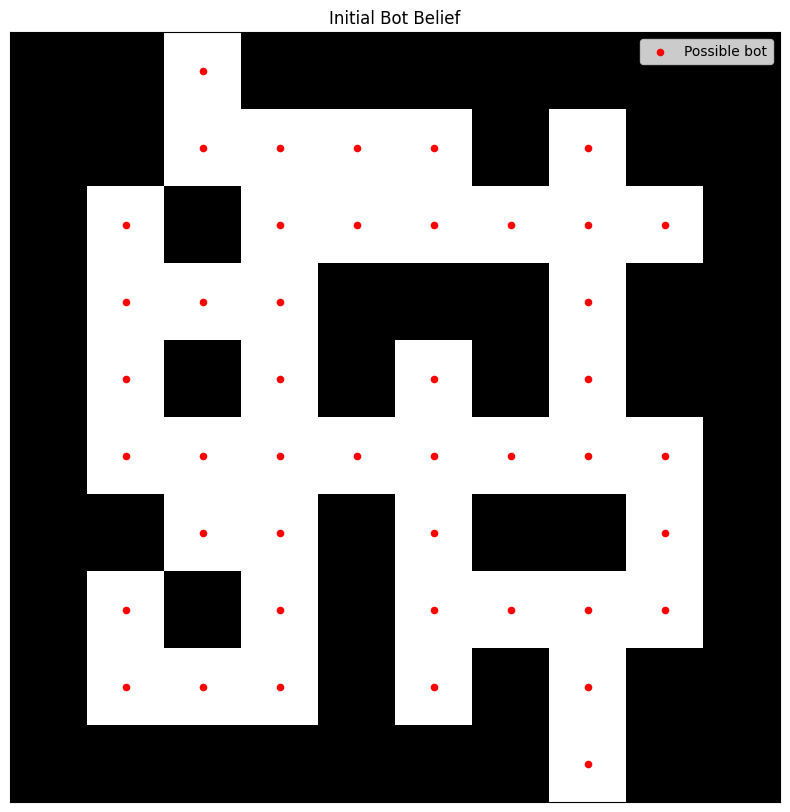

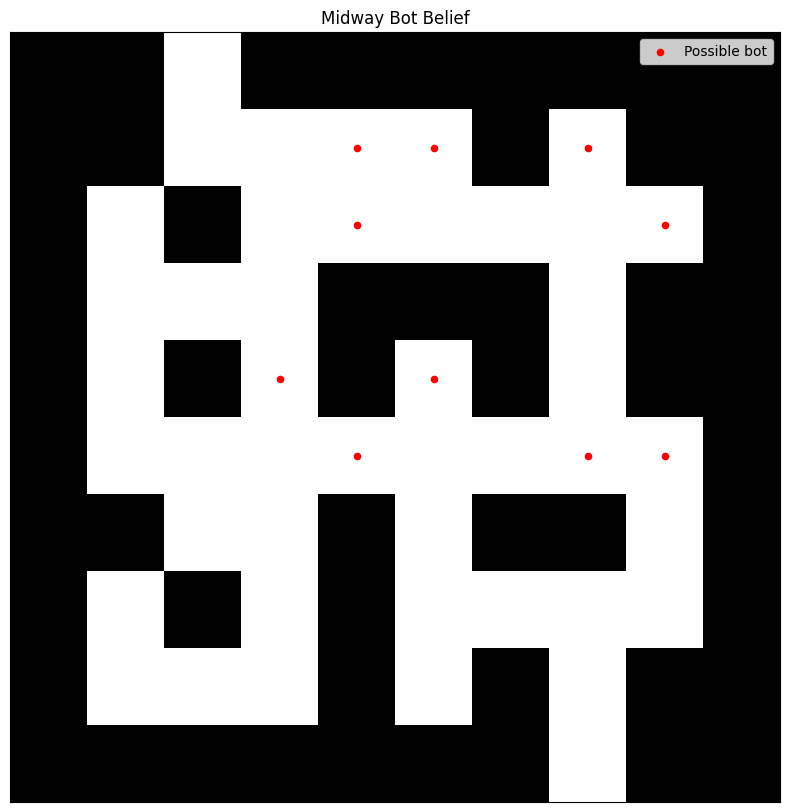

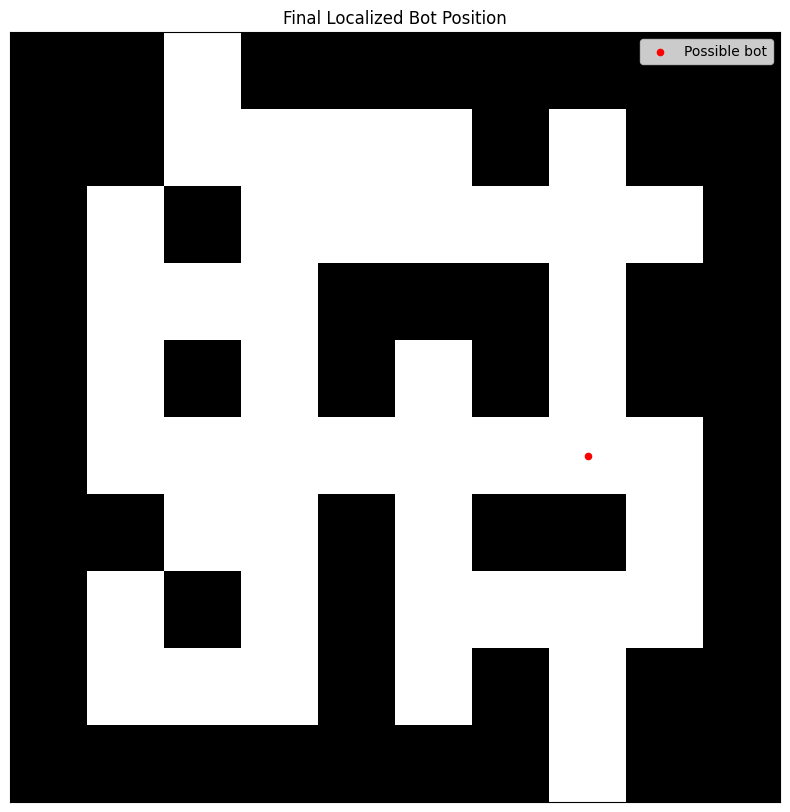

In [ ]:
show_initial_mid_final(ship, sequence, mode="all")

In [ ]:
ship_sizes = [4, 5, 6, 7, 8, 9, 10]
num_samples = 5
baseline_moves = []
optimal_moves = []

for D in ship_sizes:
  baseline_total = 0
  optimal_total = 0

  for _ in range(num_samples):
    ship = ship_generator(D=D, loop_chance=0.5, seed=42)
    dist_from_to = precompute_distances(ship)

    sequence_baseline, _ = baseline_strategy(ship)
    baseline_total += len(sequence_baseline)

    sequence_optimal, _ = optimal_a_star_strategy(ship, dist_from_to, mode="all")
    optimal_total += len(sequence_optimal) if sequence_optimal else 0

  baseline_moves.append(baseline_total / num_samples)
  optimal_moves.append(optimal_total / num_samples)

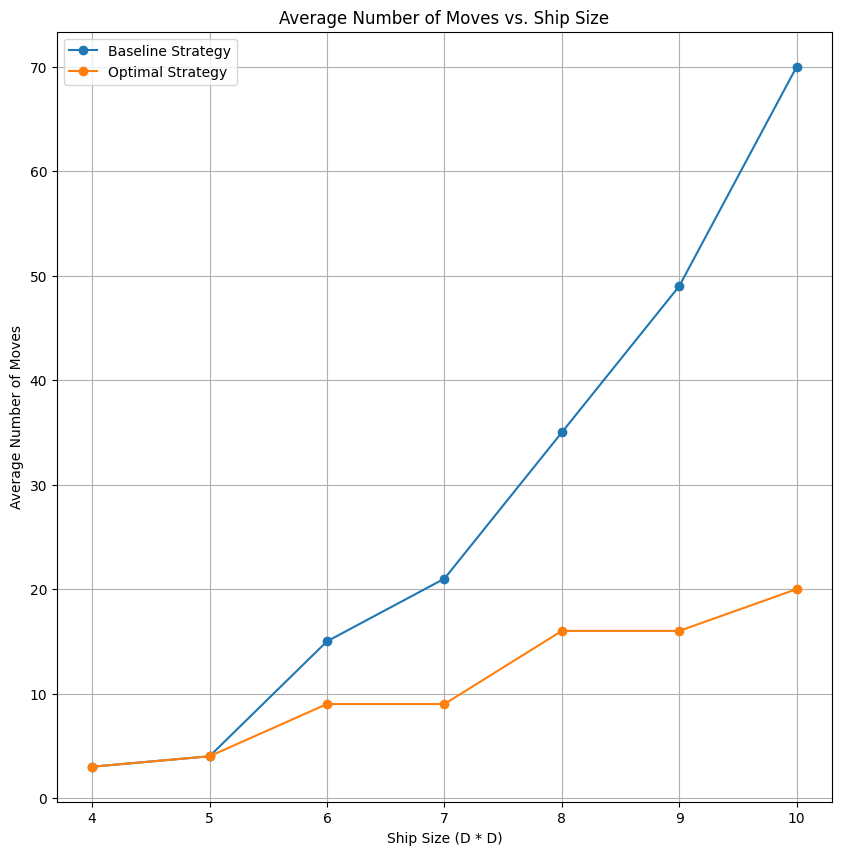

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ship_sizes, baseline_moves, label='Baseline Strategy', marker='o')
plt.plot(ship_sizes, optimal_moves, label='Optimal Strategy', marker='o')
plt.xlabel('Ship Size (D * D)')
plt.ylabel('Average Number of Moves')
plt.title('Average Number of Moves vs. Ship Size')
plt.legend()
plt.grid(True)
plt.show()

# Efficient Strategy

In [ ]:
def initialize_belief(ship, mode="all"):
  belief = np.zeros_like(ship, dtype=float)
  open_cells = np.argwhere(ship == 0)

  if mode == "all":
    selected_cells = open_cells
  elif mode =="hardest":
    selected_cells = [cell for cell in open_cells if (cell[0] + cell[1]) % 2 == 0]
    if len(selected_cells) < len(open_cells) / 3:
      selected_cells = open_cells
  else:
    raise ValueError(f"Invalid mode {mode}. Choose 'all' or 'hardest'.")

  probability = 1 / len(selected_cells)

  for i, j in selected_cells:
    belief[i, j] = probability

  return belief

In [ ]:
def move_belief(belief, ship, direction):
  if direction == 'UP':
    shifted = np.roll(belief, -1, axis=0)
    shifted[-1, :] = 0
  elif direction == 'DOWN':
    shifted = np.roll(belief, 1, axis=0)
    shifted[0, :] = 0
  elif direction == 'LEFT':
    shifted = np.roll(belief, -1, axis=1)
    shifted[:, -1] = 0
  elif direction == 'RIGHT':
    shifted = np.roll(belief, 1, axis=1)
    shifted[:, 0] = 0

  shifted[ship != 0] = 0
  shifted /= shifted.sum()

  return shifted

In [ ]:
def probability_localization(ship, mode):
  belief = initialize_belief(ship, mode=mode)
  sequence = []

  actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

  for step in range(ship.shape[0] * 10):
    # Cycle through actions deterministically
    action = actions[step % 4]
    belief = move_belief(belief, ship, action)

    # Identify the cell with the highest probability (most likely bot location)
    max_idx = np.unravel_index(np.argmax(belief), belief.shape)

    # Reinforce confidence in the most likely position (greedy refinement)
    belief[max_idx] += 0.05
    belief /= belief.sum()

    # Stop early if the bot is localized with high confidence (> 90%)
    sequence.append(action)

    if np.max(belief) > 0.9:
      break

  # Return final most probable positions and the sequence of actions taken
  final_position = np.argwhere(belief == np.max(belief))
  return sequence, final_position, belief

In [ ]:
def show_ship(ship, belief, title=""):
  plt.figure(figsize=(10, 10))
  plt.imshow(ship, cmap="gray_r")
  plt.imshow(belief, cmap="Blues", alpha=0.6)
  plt.colorbar(label="Belief Probability")
  plt.title(title)
  plt.show()

In [ ]:
ship = ship_generator(D=10, loop_chance=0.5, seed=42)

start = time.time()
sequence, final_position, belief = probability_localization(ship, mode='all')
end = time.time()

print('Efficient Move Sequence: ', sequence)
print("Moves:", len(sequence))
print("Final position:", final_position)
print("Runtime (s):", end - start)

Efficient Move Sequence:  ['UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT']
Moves: 48
Final position: [[2 4]]
Runtime (s): 0.005158424377441406


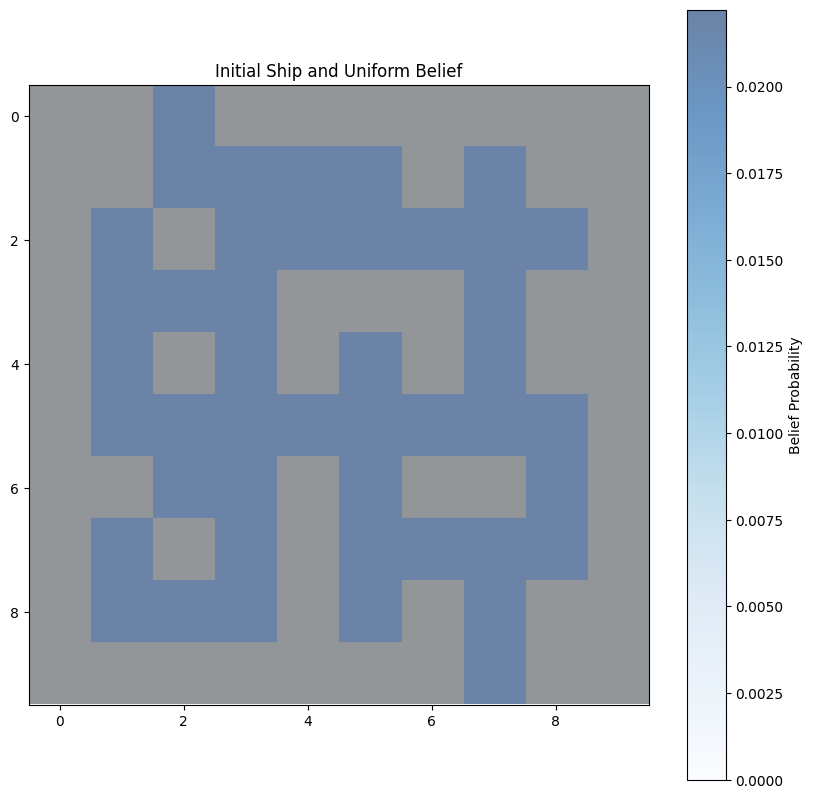

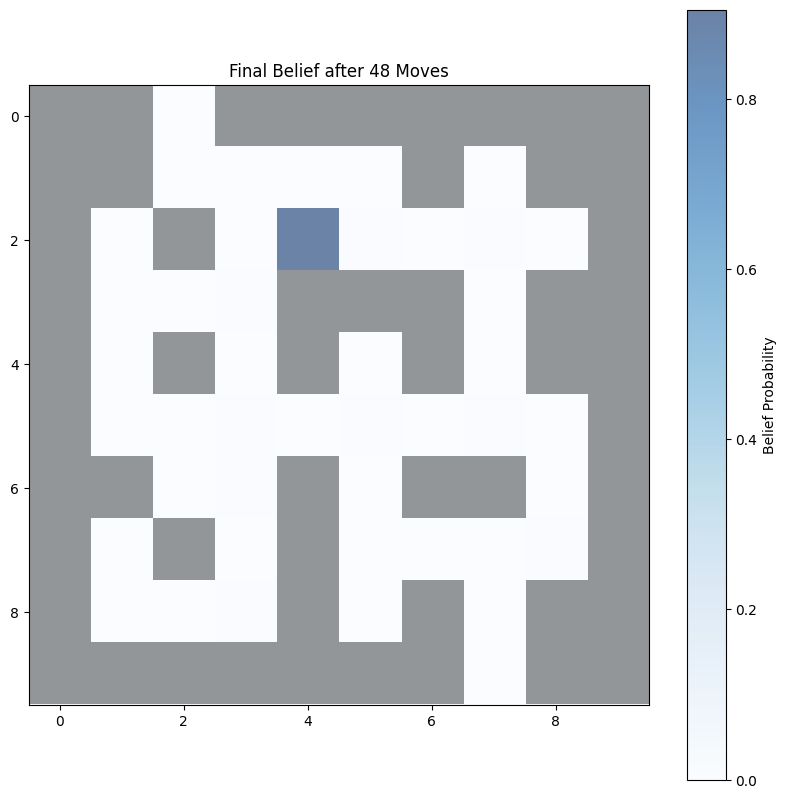

In [ ]:
belief_init = initialize_belief(ship, mode="all")
show_ship(ship, belief_init, title="Initial Ship and Uniform Belief")

show_ship(ship, belief, title=f"Final Belief after {len(sequence)} Moves")

In [ ]:
ship_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
num_samples = 5
baseline_moves = []
efficient_moves = []

for D in ship_sizes:
  baseline_total = 0
  efficient_total = 0

  for _ in range(num_samples):
    ship = ship_generator(D=D, loop_chance=0.5, seed=42)

    sequence_baseline, _ = baseline_strategy(ship)
    baseline_total += len(sequence_baseline)

    sequence_efficient, _, _= probability_localization(ship, mode="all")
    efficient_total += len(sequence_efficient)

  baseline_moves.append(baseline_total / num_samples)
  efficient_moves.append(efficient_total / num_samples)

/tmp/ipython-input-665249040.py:16: RuntimeWarning: invalid value encountered in divide
  shifted /= shifted.sum()


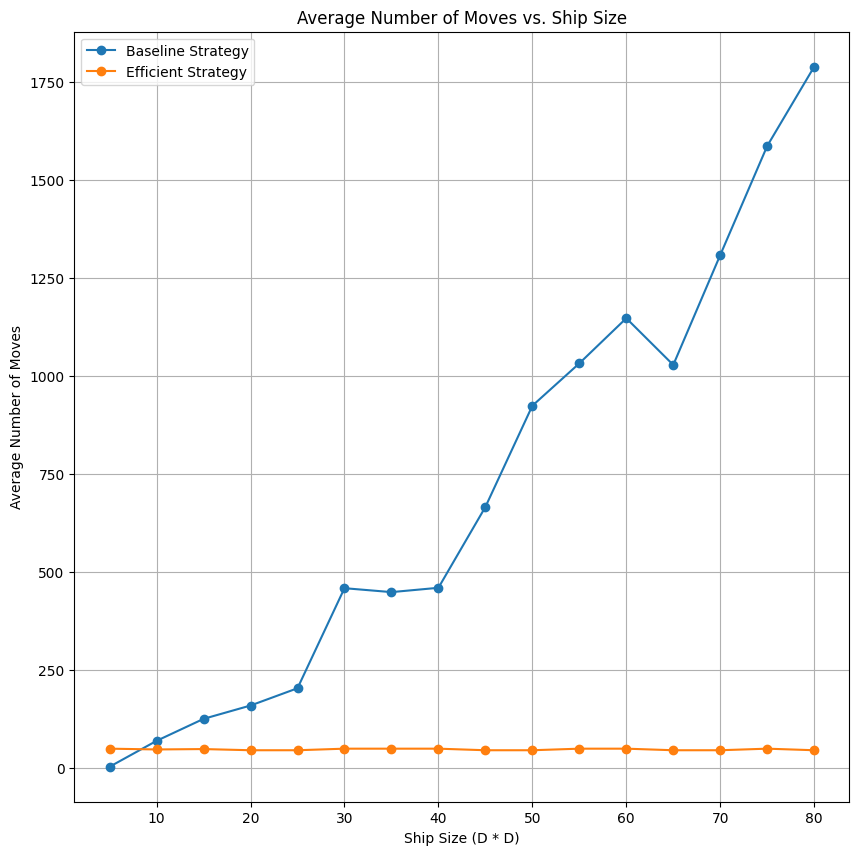

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ship_sizes, baseline_moves, label='Baseline Strategy', marker='o')
plt.plot(ship_sizes, efficient_moves, label='Efficient Strategy', marker='o')
plt.xlabel('Ship Size (D * D)')
plt.ylabel('Average Number of Moves')
plt.title('Average Number of Moves vs. Ship Size')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
baseline_times = []
efficient_times = []

for D in ship_sizes:
    baseline_total_time = 0
    efficient_total_time = 0

    for _ in range(num_samples):
        ship = ship_generator(D=D, loop_chance=0.5, seed=42)

        start = time.time()
        sequence_baseline, _ = baseline_strategy(ship)
        baseline_total_time += (time.time() - start)

        start = time.time()
        sequence_efficient, _, _ = probability_localization(ship, mode="all")
        efficient_total_time += (time.time() - start)

    baseline_times.append(baseline_total_time / num_samples)
    efficient_times.append(efficient_total_time / num_samples)

/tmp/ipython-input-665249040.py:16: RuntimeWarning: invalid value encountered in divide
  shifted /= shifted.sum()


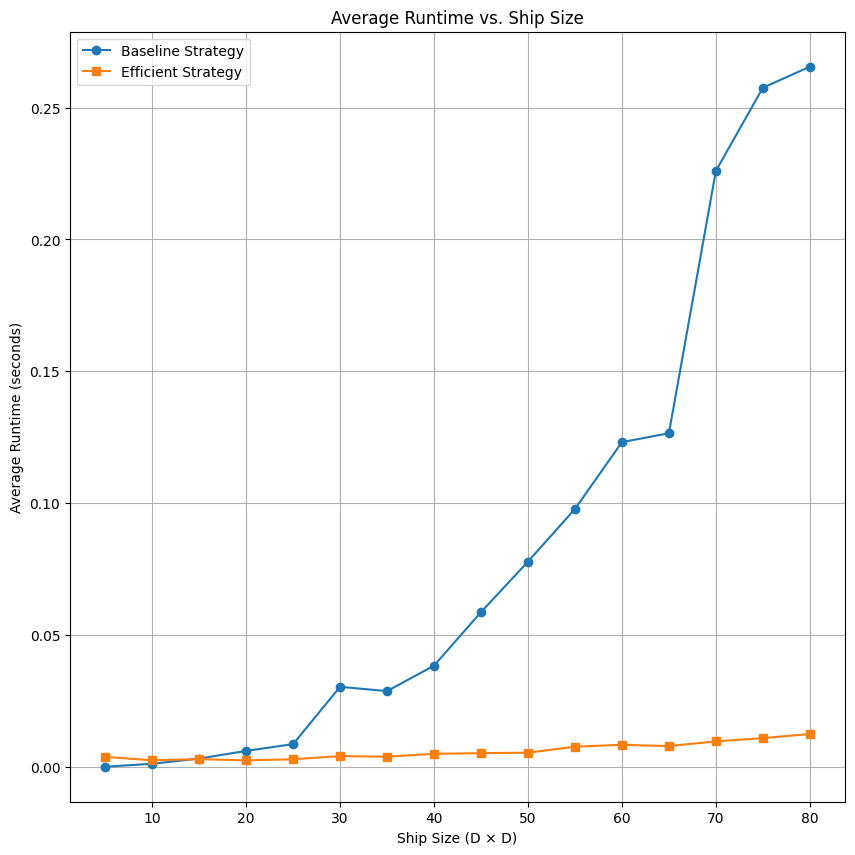

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ship_sizes, baseline_times, marker='o', label='Baseline Strategy')
plt.plot(ship_sizes, efficient_times, marker='s', label='Efficient Strategy')
plt.xlabel('Ship Size (D × D)')
plt.ylabel('Average Runtime (seconds)')
plt.title('Average Runtime vs. Ship Size')
plt.legend()
plt.grid(True)
plt.show()

# Question 5

In [ ]:
ship = ship_generator(D=10, loop_chance=0.5, seed=42)
dist_from_to = precompute_distances(ship)

start_time = time.time()
sequence_opt, final_pos_opt = optimal_a_star_strategy(ship, dist_from_to=dist_from_to, mode="hardest")
end_time = time.time()

print("Optimal Move Sequence:", sequence_opt)
print("Total moves:", len(sequence_opt))
print("Final position:", final_pos_opt)
print("Runtime (s):", end_time - start_time)

Optimal Move Sequence: ['DOWN', 'RIGHT', 'DOWN', 'DOWN', 'DOWN', 'DOWN', 'RIGHT', 'UP', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'UP']
Total moves: 17
Final position: frozenset({(5, 8)})
Runtime (s): 0.023448944091796875


In [ ]:
ship = ship_generator(D=10, loop_chance=0.5, seed=42)

start_time = time.time()
sequence_eff, final_pos_eff, belief_eff = probability_localization(ship, mode="hardest")
end_time = time.time()

print("Efficient Move Sequence:", sequence_eff)
print("Total moves:", len(sequence_eff))
print("Final position:", final_pos_eff)
print("Runtime (s):", end_time - start_time)

Efficient Move Sequence: ['UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'LEFT', 'RIGHT']
Total moves: 40
Final position: [[2 4]]
Runtime (s): 0.004754781723022461


In [ ]:
# Optimal strategy
ship_sizes = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
num_samples = 3

optimal_moves, optimal_times = [], []

for D in ship_sizes:
  total_moves_opt, total_time_opt  = 0, 0

  for _ in range(num_samples):
    ship = ship_generator(D=D, loop_chance=0.5)

    start = time.time()
    dist_from_to = precompute_distances(ship)
    seq_opt, final_opt = optimal_a_star_strategy(ship, dist_from_to=dist_from_to, mode="hardest")
    opt_time = time.time() - start
    total_time_opt += opt_time
    total_moves_opt += len(seq_opt) if seq_opt else 0

  optimal_moves.append(total_moves_opt / num_samples)
  optimal_times.append(total_time_opt / num_samples)

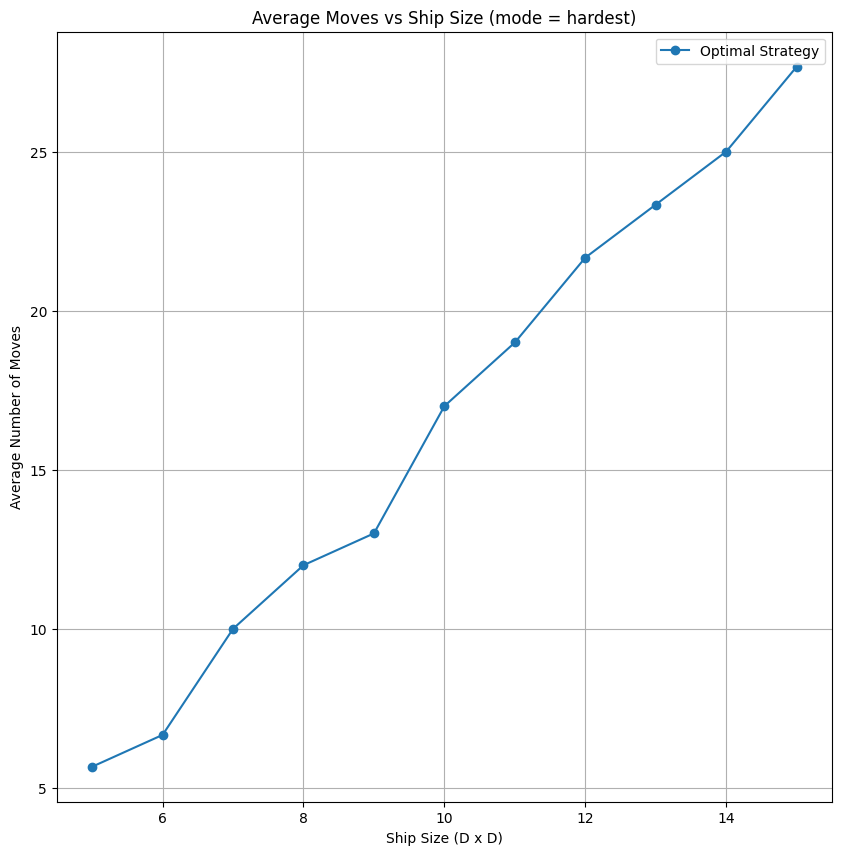

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ship_sizes, optimal_moves, 'o-', label='Optimal Strategy')
plt.xlabel("Ship Size (D x D)")
plt.ylabel("Average Number of Moves")
plt.title("Average Moves vs Ship Size (mode = hardest)")
plt.legend()
plt.grid(True)
plt.show()

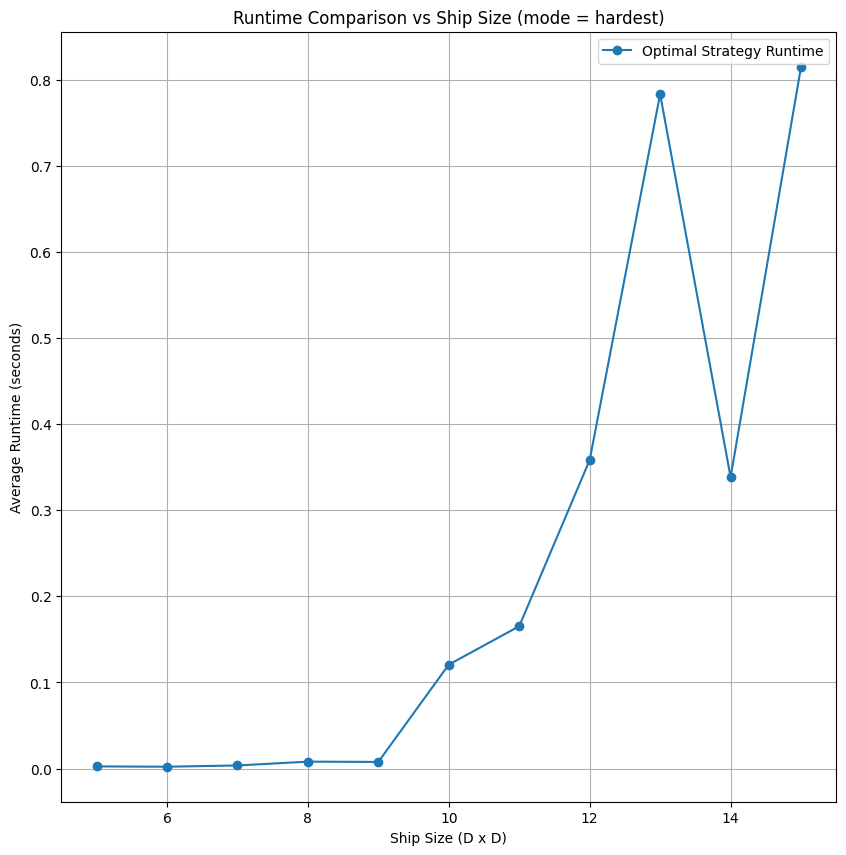

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ship_sizes, optimal_times, 'o-', label='Optimal Strategy Runtime')
plt.xlabel("Ship Size (D x D)")
plt.ylabel("Average Runtime (seconds)")
plt.title("Runtime Comparison vs Ship Size (mode = hardest)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Efficient Strategy
ship_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
num_samples = 3

efficient_moves, efficient_times = [], []

for D in ship_sizes:
  total_moves_eff, total_time_eff = 0, 0

  for _ in range(num_samples):
    ship = ship_generator(D=D, loop_chance=0.5)

    start = time.time()
    seq_eff, _, _ = probability_localization(ship, mode="hardest")
    eff_time = time.time() - start
    total_time_eff += eff_time
    total_moves_eff += len(seq_eff)

  efficient_moves.append(total_moves_eff / num_samples)
  efficient_times.append(total_time_eff / num_samples)

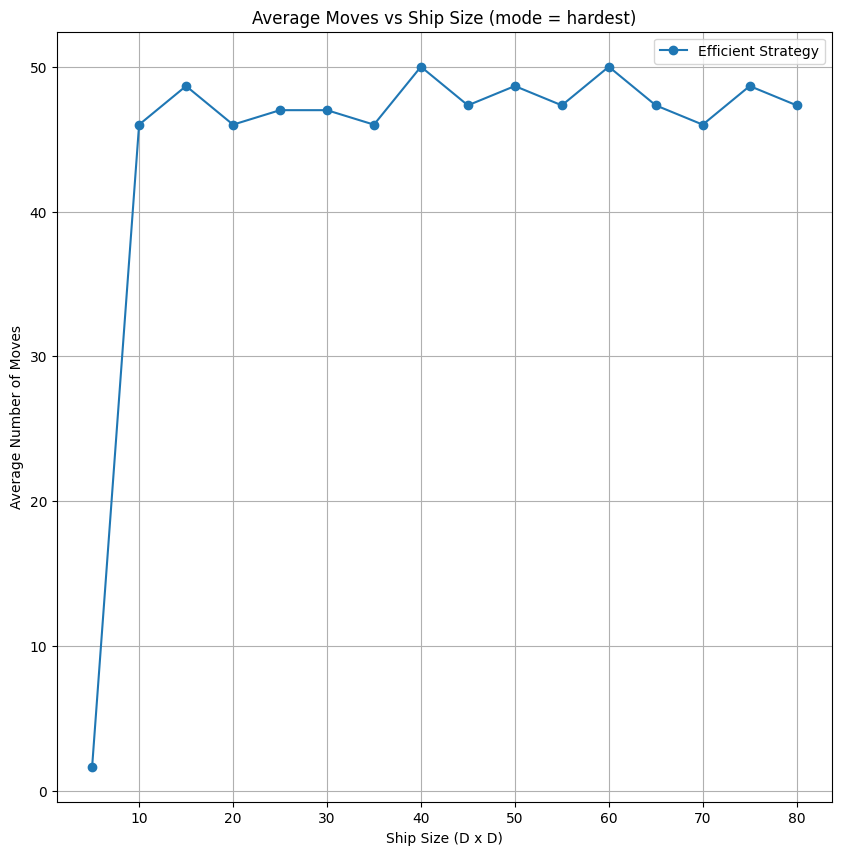

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ship_sizes, efficient_moves, 'o-', label='Efficient Strategy')
plt.xlabel("Ship Size (D x D)")
plt.ylabel("Average Number of Moves")
plt.title("Average Moves vs Ship Size (mode = hardest)")
plt.legend()
plt.grid(True)
plt.show()

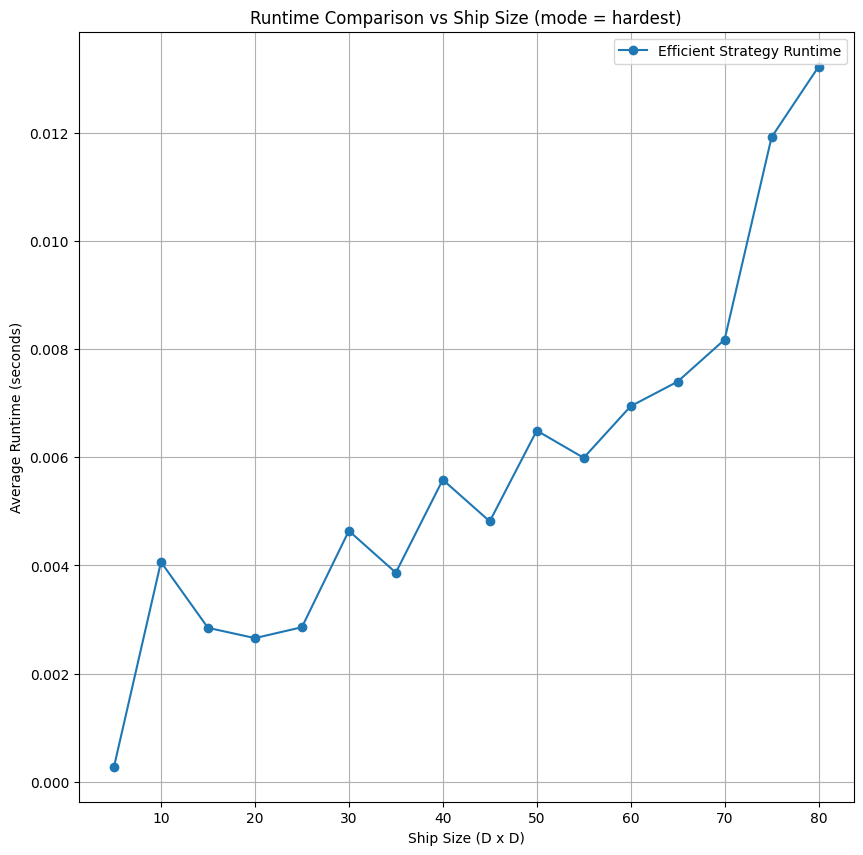

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ship_sizes, efficient_times, 'o-', label='Efficient Strategy Runtime')
plt.xlabel("Ship Size (D x D)")
plt.ylabel("Average Runtime (seconds)")
plt.title("Runtime Comparison vs Ship Size (mode = hardest)")
plt.legend()
plt.grid(True)
plt.show()